<a href="https://colab.research.google.com/github/Orasz/BIMCV-COVID19/blob/main/resnet50CustomWithReLUfullDatasetCG1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

example of Transfer Learning using QaTa-COV19 dataset.

In [11]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [12]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode
print("done")

done


In [13]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms_xray = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'gdrive/MyDrive/datasetQaTa/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms_xray[x])
                  for x in ['train', 'val']}
#aumenta batch size 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print("Dataset sizes: {}".format(dataset_sizes))
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using device: {}".format(device))

using device: cuda:0


In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#imshow(out, title=[class_names[x] for x in classes])

done


In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        t1 = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            t2 = time.time()
            print('time:{}'.format(t2-t1))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

print("done")

done


In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
print("done")

done


In [23]:
#Dropout added in FC Layer, should it be added between each Conv.Layer as well/instead?
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
print(model_ft.fc)
print(num_ftrs)
 
#custom classifier layer for binary classification
#Activation function used but results are the same with or without it.
#It should be noted that in Library/Pytorch implementation of ResNet 50 the output of the fc layer is the final output, without calling softMax on it.
model_ft.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(512,2)
)
print("Fully connected layer after optimization:")
print(model_ft.fc)
model_ft = model_ft.to(device)

#CrossEntropyLoss works well, but for segmentation maybe FocalLoss is better
criterion = nn.CrossEntropyLoss()

#Settin learning reate to 10^-5, it should make the learning process more stable
optimizer_adam = optim.Adam(model_ft.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_adam, step_size=7, gamma=0.1)
print("done")

Linear(in_features=2048, out_features=1000, bias=True)
2048
Fully connected layer after optimization:
Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=2048, out_features=1024, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=512, out_features=2, bias=True)
)
done


In [24]:
model_ft = train_model(model_ft, criterion, optimizer_adam, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3495 Acc: 0.8964
time:148.96897506713867
val Loss: 0.0831 Acc: 0.9723
time:163.0735321044922

Epoch 1/24
----------
train Loss: 0.0566 Acc: 0.9840
time:148.3684961795807
val Loss: 0.0365 Acc: 0.9848
time:162.8489043712616

Epoch 2/24
----------
train Loss: 0.0195 Acc: 0.9955
time:148.05895233154297
val Loss: 0.0193 Acc: 0.9951
time:162.50731325149536

Epoch 3/24
----------
train Loss: 0.0106 Acc: 0.9973
time:148.29477310180664
val Loss: 0.0139 Acc: 0.9967
time:162.5903344154358

Epoch 4/24
----------
train Loss: 0.0063 Acc: 0.9988
time:148.79692268371582
val Loss: 0.0185 Acc: 0.9940
time:163.0294201374054

Epoch 5/24
----------
train Loss: 0.0027 Acc: 0.9992
time:148.54640555381775
val Loss: 0.0163 Acc: 0.9951
time:163.03582119941711

Epoch 6/24
----------
train Loss: 0.0050 Acc: 0.9984
time:149.54295682907104
val Loss: 0.0164 Acc: 0.9957
time:164.1627163887024

Epoch 7/24
----------
train Loss: 0.0021 Acc: 0.9997
time:148.80921816825867
val Loss: 0.

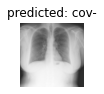

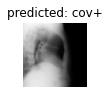

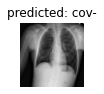

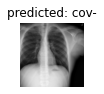

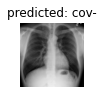

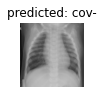

In [ ]:
visualize_model(model_ft)